# Navier Stokes Equatoin

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la

# --- Core imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div
)
from pycutfem.ufl.measures import dx
from pycutfem.ufl.forms import BoundaryCondition, assemble_form
from pycutfem.fem.mixedelement import MixedElement

# 1. ============================================================================
#    SETUP (Meshes, DofHandler, BCs)
# ===============================================================================
L, H = 1.0, 1.0
NX, NY = 16, 6 # Increased resolution for better visualization
nodes_q2, elems_q2, _, corners_q2 = structured_quad(L, H, nx=NX, ny=NY, poly_order=2)
mesh_q2 = Mesh(nodes=nodes_q2, element_connectivity=elems_q2, elements_corner_nodes=corners_q2, element_type="quad", poly_order=2)
mixed_element = MixedElement(mesh_q2, field_specs={'ux': 2, 'uy': 2, 'p': 1})

dof_handler = DofHandler(mixed_element, method='cg')


# Tag boundaries for applying BCs
bc_tags = {
    'bottom_wall': lambda x,y: np.isclose(y,0),
    'left_wall':   lambda x,y: np.isclose(x,0),
    'right_wall':  lambda x,y: np.isclose(x,L),
    'top_lid':     lambda x,y: np.isclose(y,H)
}
mesh_q2.tag_boundary_edges(bc_tags)

# Tag a single node for pressure pinning
dof_handler.tag_dof_by_locator(
        tag='pressure_pin_point',
        field='p',
        locator=lambda x, y: np.isclose(x, 0) and np.isclose(y, 0),
        find_first=True
    )

class DataBC:
    Um = 1.5 # Lid velocity
    H = H
    T = 2.0 # Total time for simulation
    
# bcs = [
#     # No-slip on bottom, left, and right walls
#     BoundaryCondition('ux', 'dirichlet', 'bottom_wall', lambda x,y:0.0),
#     BoundaryCondition('uy', 'dirichlet', 'bottom_wall', lambda x,y:0.0),
#     BoundaryCondition('ux', 'dirichlet', 'left_wall',   lambda x,y: 4 * DataBC.Um * y * (DataBC.H-y) / (DataBC.H**2)),
#     BoundaryCondition('uy', 'dirichlet', 'left_wall',   lambda x,y:0.0),
#     BoundaryCondition('ux', 'dirichlet', 'right_wall',  lambda x,y:0.0),
#     BoundaryCondition('uy', 'dirichlet', 'right_wall',  lambda x,y:0.0),
#     # Moving lid on the top wall
#     BoundaryCondition('ux', 'dirichlet', 'top_lid',     lambda x,y:0.0),
#     BoundaryCondition('uy', 'dirichlet', 'top_lid',    lambda x,y:0.0),
#     # Pin pressure at one point to ensure a unique solution
#     BoundaryCondition('p', 'dirichlet', 'pressure_pin_point',lambda x,y: 0.0)
# ]
t=0.0

bcs = [
    # No-slip on bottom, left, and right walls
    BoundaryCondition('ux', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'bottom_wall', lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'left_wall',   lambda x,y: 0.0),
    BoundaryCondition('ux', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    BoundaryCondition('uy', 'dirichlet', 'right_wall',  lambda x,y: 0.0),
    # Moving lid on the top wall
    BoundaryCondition('ux', 'dirichlet', 'top_lid',     lambda x,y,t: DataBC.Um * np.sin(t * np.pi)), # Corrected: Was 0.0
    BoundaryCondition('uy', 'dirichlet', 'top_lid',     lambda x,y: 0.0),
    # Pin pressure at one point to ensure a unique solution
    BoundaryCondition('p', 'dirichlet', 'pressure_pin_point', lambda x,y: 0.0)
]

# Create the corresponding homogeneous BCs for the Newton update
bcs_homog = [
    BoundaryCondition(bc.field, bc.method, bc.domain_tag,lambda x,y: 0.0) for bc in bcs
]

print(f"Naviver info: {dof_handler.info()}")

=== DofHandler (CG) ===
        ux: 429 DOFs @ offset 0
        uy: 429 DOFs @ offset 9
         p: 119 DOFs @ offset 18
  total : 977
Naviver info: None


In [2]:
# 2. ============================================================================
#    UFL FORMULATION
# ===============================================================================

# --- Define Constants and Function Spaces ---
rho = Constant(1.0)
dt = Constant(0.1)
theta = Constant(0.5) # Crank-Nicolson
mu = Constant(1.0e-1)

velocity_space = FunctionSpace("velocity", ['ux', 'uy'])
pressure_space = FunctionSpace("pressure", ['p'])

# --- Define all required UFL Functions ---
# Trial functions for the Jacobian system (the corrections)
du = VectorTrialFunction(velocity_space, dof_handler=dof_handler)
dp = TrialFunction(pressure_space, dof_handler=dof_handler)

# Test functions
v = VectorTestFunction(velocity_space, dof_handler=dof_handler)
q = TestFunction(pressure_space, dof_handler=dof_handler)

# Functions to hold solutions at different time steps/iterations
# u_k/p_k are the current Newton iteration k at time t_n+1
# u_n/p_n are the converged solution from the previous time step t_n
u_k = VectorFunction(name="u_k", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_k = Function(name="p_k", field_name='p', dof_handler=dof_handler)
u_n = VectorFunction(name="u_n", field_names=['ux', 'uy'], dof_handler=dof_handler)
p_n = Function(name="p_n", field_name='p', dof_handler=dof_handler)

# --- Define Residual R(u_k, p_k) and Jacobian J ---
# The residual is the transient Navier-Stokes equation F(U_k) = 0
# where U_k = (u_k, p_k)

In [3]:


jacobian = (
    # Time derivative term: d/dt(u) -> du/dt
    rho * dot(du, v) / dt  
    
    # Convection term: theta * [ ((du ⋅ ∇)u_k) ⋅ v + ((u_k ⋅ ∇)du) ⋅ v ]
    +theta * rho * dot(dot(grad(u_k),du ) , v)  
    +theta * rho * dot(dot(grad(du),u_k ), v)   

    # Diffusion term: theta * mu * (∇du : ∇v)
    +theta * mu * inner(grad(du), grad(v)) 
    
    # Pressure term: -theta * dp * (∇⋅v)
    -dp * div(v)  
    
    # Continuity term: q * (∇⋅du)
    +q * div(du) 
) * dx()

residual = (
    # Time derivative: -(u_k - u_n)/dt ⋅ v
    rho * dot(u_k - u_n, v) / dt  
    + (rho*theta) * dot(  dot(grad(u_k),u_k ) , v) 
    + (rho - (rho*theta)) * dot(   dot(grad(u_n),u_n   ) , v) 
    # Diffusion terms at theta and (1-theta)
    +(theta * mu * inner(grad(u_k), grad(v)) ) 
    +((1.0 - theta) * mu * inner(grad(u_n), grad(v)) ) 
    
    # Pressure terms
    - p_k * div(v) 
    # Continuity term
    +q * div(u_k)  
    
    ) * dx()



In [4]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters

# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=0.1, stop_on_steady=False, steady_tol=1e-6, theta=1.0, final_time=DataBC.T)

solver = NewtonSolver(
    residual, jacobian,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, 
    bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6),
)

# primary unknowns
functions      = [u_k, p_k]
prev_functions = [u_n, p_n]

solver.solve_time_interval(functions=functions,prev_functions= prev_functions,
                           time_params=time_params,)

        Newton 1: |R|_∞ = 0.00e+00
        Newton 1: |R|_∞ = 1.33e-02
        Line search failed – proceeding with full step anyway.
        Newton 2: |R|_∞ = 5.84e-05
        Line search failed – proceeding with full step anyway.
        Newton 3: |R|_∞ = 7.72e-10
        Newton 1: |R|_∞ = 3.09e-02
        Line search failed – proceeding with full step anyway.
        Newton 2: |R|_∞ = 2.64e-04
        Line search failed – proceeding with full step anyway.
        Newton 3: |R|_∞ = 1.46e-08
        Newton 1: |R|_∞ = 2.87e-02
        Line search failed – proceeding with full step anyway.
        Newton 2: |R|_∞ = 1.69e-04
        Line search failed – proceeding with full step anyway.
        Newton 3: |R|_∞ = 7.57e-09
        Newton 1: |R|_∞ = 2.20e-02
        Line search failed – proceeding with full step anyway.
        Newton 2: |R|_∞ = 1.16e-04
        Line search failed – proceeding with full step anyway.
        Newton 3: |R|_∞ = 2.67e-09
        Newton 1: |R|_∞ = 1.28e-02
      

(array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00271043e-04, -4.19894940e-04,  0.00000000e+00, -2.63890344e-04,
        -8.83842885e-04,  0.00000000e+00,  0.00000000e+00, -9.21090730e-04,
        -1.59309070e-03, -1.79317386e-03, -2.91223081e-03,  0.00000000e+00,
         0.00000000e+00, -2.37364076e-03, -3.22687327e-03, -4.18348509e-03,
        -5.54689174e-03,  0.00000000e+00,  0.00000000e+00, -4.10566999e-03,
        -4.97379766e-03, -6.94095189e-03, -8.31135379e-03,  0.00000000e+00,
         0.00000000e+00, -5.80068087e-03, -6.55452785e-03, -9.60969957e-03,
        -1.07932883e-02,  0.00000000e+00,  0.00000000e+00, -7.22080242e-03,
        -7.77494313e-03, -1.18333731e-02, -1.27003126e-02,  0.00000000e+00,
         0.00000000e+00, -8.21489702e-03, -8.52319201e-03, -1.33831227e-02,
        -1.38640106e-02,  0.00000000e+00,  0.00000000e+00, -8.70613913e-03,
        -8.75223858e-03, -1.41442408e-02, -1.42150438e-02,  0.00000000e+00,
         0.0

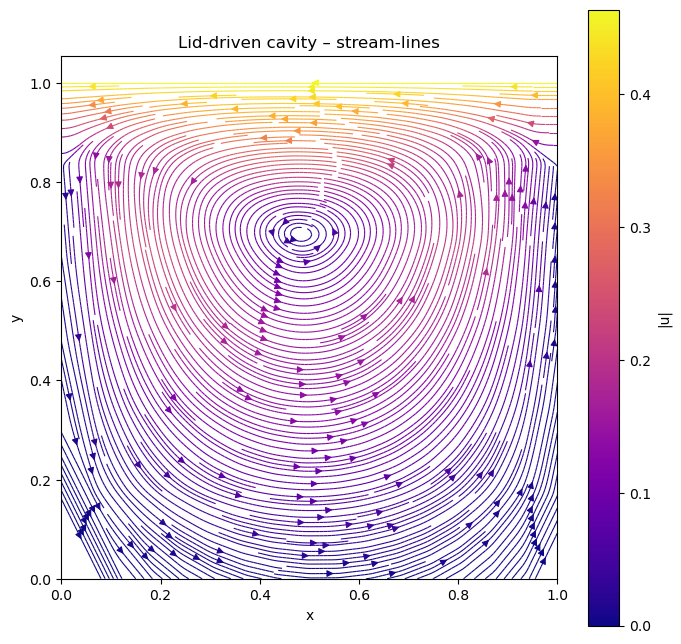

In [5]:
u_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Lid-driven cavity – stream-lines",background = False)